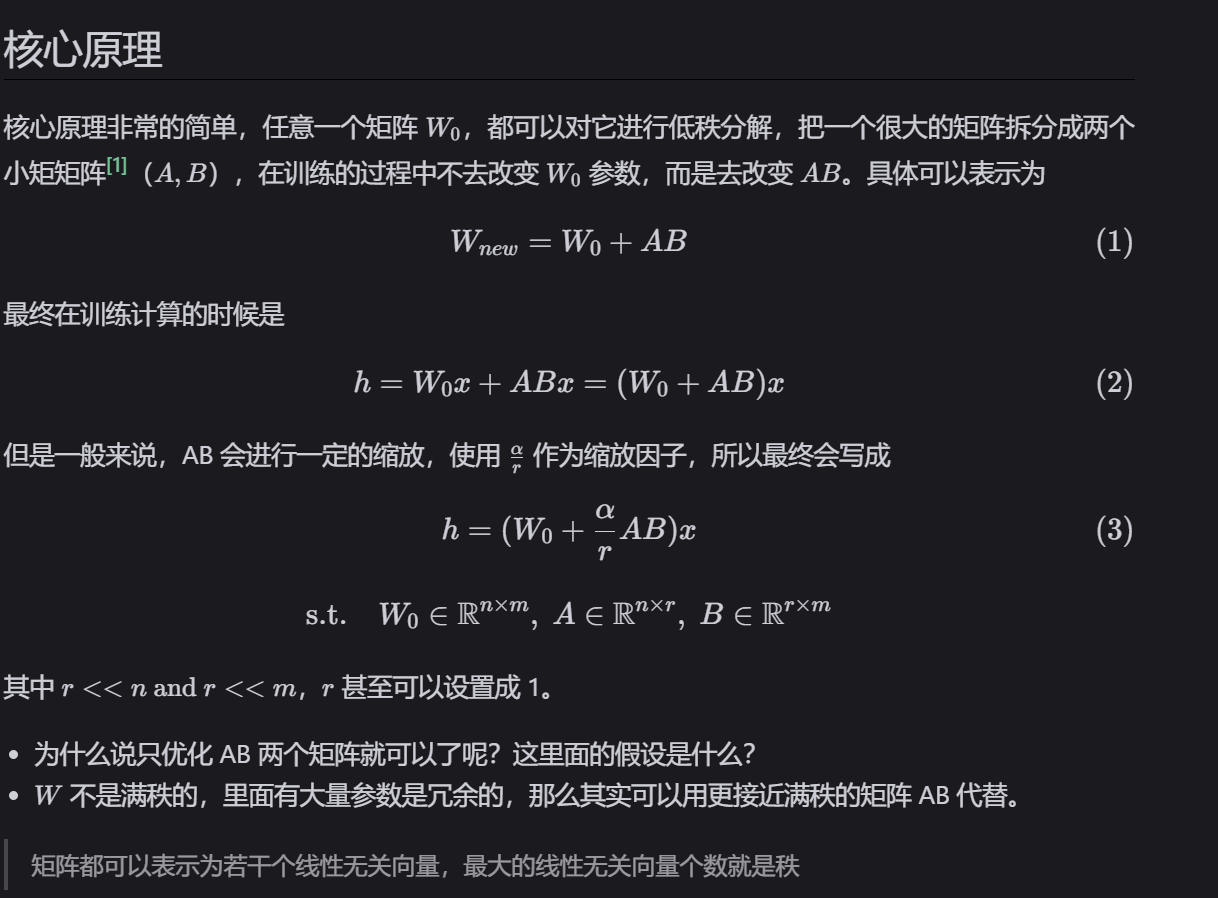

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math

In [2]:
class LinearLoraLayer(nn.Module):
    def __init__(self, 
                 in_features, 
                 out_features, 
                 rank, 
                 lora_alpha, 
                 dropout,
                 merge = False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        self.lora_alpha = lora_alpha
        self.dropout = dropout
        self.merge = merge

        # Linear: weight 的 shape: (out_features, in_features)
        # input x shape: (batch_size, seq_len, in_features)
        # 计算过程是 x @ weight.T

        self.linear = nn.Linear(in_features, out_features)

        if rank > 0:
            # lora_a 是一个高斯分布
            self.lora_a = nn.Parameter(
                torch.zeros(out_features,rank)
                )
            # 在调用凯明初始化的时候注释里写的高斯分布normal，不应该调用均匀分布uniform，a表示的是leaky relu的负斜率系数，一般是0.01这样的小值，不可能超过1
            nn.init.kaiming_normal_(self.lora_a, a=0.01)
            self.lora_b = nn.Parameter(
                torch.zeros(rank, in_features)
            )
            self.scale = lora_alpha / rank
            # linear 需要设置为不可以训练
            self.linear.weight.requires_grad = False
            self.linear.bias.requires_grad = False

        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        # merge是bool类型，如果为True，则将lora权重和linear权重合并
        if merge:
            self.merge_weight()

    def merge_weight(self, ):
        if self.merge and self.rank > 0:
            # weight shape: (output_features, rank) @ (rank, in_features)
            self.linear.weight.data += self.scale * (self.lora_a @ self.lora_b)

    def unmerge_weight(self, ):
        if self.merge and self.rank > 0:
            self.linear.weight.data -= self.scale * (self.lora_a @ self.lora_b)

    def forward(self, X):
        # X shape: (batch_size, seq_len, in_features)
        
        if self.rank > 0:
            output_part1 = self.linear(X)
            output_part2 = self.scale * (X @ (self.lora_a @ self.lora_b).T) 
            output = output_part1 + output_part2    # 这种加法的方式比较好
        else:
            output = self.linear(X)

        output = self.dropout(output)
        return output

In [3]:
# 写一段测试代码
# Test the LoRALinear layer
batch_size = 32
seq_len = 128
in_features = 768
out_features = 512
rank = 8
lora_alpha = 16
dropout = 0.1

# Create a test input
x = torch.randn(batch_size, seq_len, in_features)

# Test regular mode (no merge)
lora_layer = LinearLoraLayer(
    in_features=in_features,
    out_features=out_features,
    rank=rank,
    lora_alpha=lora_alpha,
    dropout=dropout,
    merge=False
)

# Forward pass
output = lora_layer(x)
print(f"Output shape (no merge): {output.shape}")  # Should be [batch_size, seq_len, out_features]

# Test merged mode
lora_layer_merged = LinearLoraLayer(
    in_features=in_features,
    out_features=out_features,
    rank=rank,
    lora_alpha=lora_alpha,
    dropout=dropout,
    merge=True
)

# Forward pass with merged weights
output_merged = lora_layer_merged(x)
print(f"Output shape (merged): {output_merged.shape}")  # Should be [batch_size, seq_len, out_features]

# Test weight merging/unmerging
lora_layer.merge_weight()
output_after_merge = lora_layer(x)
lora_layer.unmerge_weight()
output_after_unmerge = lora_layer(x)

print("Max difference after merge/unmerge cycle:", 
      torch.max(torch.abs(output - output_after_unmerge)).item())

Output shape (no merge): torch.Size([32, 128, 512])
Output shape (merged): torch.Size([32, 128, 512])
Max difference after merge/unmerge cycle: 3.1414055824279785
